In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from __future__ import annotations

import json
from pathlib import Path
from typing import Any, Dict, List, Tuple

import numpy as np


def load_omega_time_ga_run(run_dir: str | Path) -> Dict[str, Any]:
    """
    Load ALL gen_*/meta.json files in a GA run directory (e.g. OmegaTimeGA_20260204_154626),
    including omega_vector and time_vector.

    Returns dict with:
      - run_dir: str
      - records: list[dict] (sorted by gen)
      - scalar: dict[str, np.ndarray]  (per-gen scalars)
      - omega_matrix: np.ndarray (G, M) or None
      - time_matrix:  np.ndarray (G, M) or None
      - unique_pairs: list[list[int]] or None  (from first meta that has it)
      - meta_paths: list[str]
      - missing_meta: list[str]
      - errors: list[tuple[str, str]]
    """
    run_dir = Path(run_dir)
    if not run_dir.is_dir():
        raise FileNotFoundError(f"Run directory not found: {run_dir}")

    gen_dirs = sorted([p for p in run_dir.iterdir() if p.is_dir() and p.name.startswith("gen_")])

    records: List[Dict[str, Any]] = []
    meta_paths: List[str] = []
    missing_meta: List[str] = []
    errors: List[Tuple[str, str]] = []

    for gd in gen_dirs:
        meta_path = gd / "meta.json"
        if not meta_path.exists():
            missing_meta.append(str(meta_path))
            continue

        try:
            with meta_path.open("r") as f:
                meta = json.load(f)

            # Fill gen from folder name if absent
            if "gen" not in meta:
                try:
                    meta["gen"] = int(gd.name.split("_", 1)[1])
                except Exception:
                    meta["gen"] = None

            meta["_meta_path"] = str(meta_path)
            records.append(meta)
            meta_paths.append(str(meta_path))
        except Exception as e:
            errors.append((str(meta_path), repr(e)))

    # Sort records by gen (fall back to path if needed)
    records.sort(key=lambda d: (d.get("gen") is None, d.get("gen", 10**9), d.get("_meta_path", "")))

    # Pull unique_pairs from first record that has it
    unique_pairs = None
    for r in records:
        if "unique_pairs" in r and r["unique_pairs"] is not None:
            unique_pairs = r["unique_pairs"]
            break

    # Helper: scalar columns
    def _scalar_col(key: str) -> np.ndarray:
        vals = []
        for r in records:
            v = r.get(key, None)
            vals.append(np.nan if v is None else v)
        try:
            return np.asarray(vals, dtype=float)
        except Exception:
            # If mixed types, coerce to object then to float where possible
            out = np.full(len(vals), np.nan, dtype=float)
            for i, v in enumerate(vals):
                try:
                    out[i] = float(v)
                except Exception:
                    pass
            return out

    scalar = {
        "gen": _scalar_col("gen"),
        "score": _scalar_col("score"),
        "n_bar": _scalar_col("n_bar"),
        "good": _scalar_col("good"),
        "survive": _scalar_col("survive"),
        "num_pulses": _scalar_col("num_pulses"),
    }

    # Build omega/time matrices (G, M) if present and consistent
    omega_lists = [r.get("omega_vector", None) for r in records]
    time_lists  = [r.get("time_vector", None) for r in records]

    def _stack_vectors(vec_lists: List[Any], name: str) -> np.ndarray | None:
        # Find first non-empty vector to determine M
        M = None
        for v in vec_lists:
            if isinstance(v, list) and len(v) > 0:
                M = len(v)
                break
        if M is None:
            return None

        mat = np.full((len(vec_lists), M), np.nan, dtype=float)
        for i, v in enumerate(vec_lists):
            if isinstance(v, list) and len(v) == M:
                mat[i, :] = np.asarray(v, dtype=float)
            elif v is None:
                continue
            else:
                # length mismatch -> leave NaNs
                # (you can raise instead if you prefer strictness)
                continue
        return mat

    omega_matrix = _stack_vectors(omega_lists, "omega_vector")
    time_matrix  = _stack_vectors(time_lists, "time_vector")

    return {
        "run_dir": str(run_dir),
        "records": records,
        "scalar": scalar,
        "omega_matrix": omega_matrix,
        "time_matrix": time_matrix,
        "unique_pairs": unique_pairs,
        "meta_paths": meta_paths,
        "missing_meta": missing_meta,
        "errors": errors,
    }


In [7]:
import numpy as np
import matplotlib.pyplot as plt


def plot_ga_metrics(run_data):
    """
    Plot score, n_bar, and good rate vs generation.

    Parameters
    ----------
    run_data : dict
        Output of load_omega_time_ga_run(...)
    """
    gen = run_data["scalar"]["gen"]
    score = run_data["scalar"]["score"]
    n_bar = run_data["scalar"]["n_bar"]
    good = run_data["scalar"]["good"]

    # Remove NaN gens if any
    mask = ~np.isnan(gen)
    gen = gen[mask].astype(int)
    score = score[mask]
    n_bar = n_bar[mask]
    good = good[mask]

    fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

    # --- Score ---
    axes[0].plot(gen, score, "-o")
    axes[0].set_ylabel("Score")
    axes[0].set_title("GA optimization progress")
    axes[0].grid(True, alpha=0.4)

    # --- n_bar ---
    axes[1].plot(gen, n_bar, "-o")
    axes[1].set_ylabel(r"$\bar{n}_z$")
    axes[1].grid(True, alpha=0.4)

    # --- Good rate ---
    axes[2].plot(gen, good, "-o")
    axes[2].set_ylabel("Good fraction")
    axes[2].set_xlabel("Generation")
    axes[2].grid(True, alpha=0.4)

    plt.tight_layout()
    plt.show()


In [16]:
import numpy as np
import matplotlib.pyplot as plt


def plot_omega_time_vs_generation_by_axis(run_data):
    """
    3 rows × 2 columns:
      Col 0: Omega vs gen (kHz) for X/Y/Z
      Col 1: Time  vs gen (µs) for X/Y/Z
    """
    gen = run_data["scalar"]["gen"]
    omega_mat = run_data["omega_matrix"]   # (G, M), Hz
    time_mat  = run_data["time_matrix"]    # (G, M), s
    unique_pairs = run_data["unique_pairs"]

    if omega_mat is None or time_mat is None or unique_pairs is None:
        raise ValueError("run_data must contain omega_matrix, time_matrix, and unique_pairs")

    # Remove NaN gens
    mask = ~np.isnan(gen)
    gen = gen[mask].astype(int)
    omega_mat = omega_mat[mask] * 1e-3   # Hz → kHz
    time_mat  = time_mat[mask] * 1e6     # s  → µs

    G, M = omega_mat.shape
    if len(unique_pairs) != M:
        raise ValueError("unique_pairs length does not match omega/time vectors")

    # Group indices by axis
    axis_to_idx = {0: [], 1: [], 2: []}
    for j, (axis, dn) in enumerate(unique_pairs):
        axis_to_idx[int(axis)].append(j)

    fig, axes = plt.subplots(3, 2, figsize=(14, 10), sharex=True)
    axis_names = {0: "X", 1: "Y", 2: "Z"}

    for row, axis in enumerate([0, 1, 2]):
        # --- Omega column ---
        ax_om = axes[row, 0]
        for j in axis_to_idx[axis]:
            _, dn = unique_pairs[j]
            ax_om.plot(gen, omega_mat[:, j], marker="o", label=f"Δn={dn}")
        ax_om.set_title(f"Ω vs Gen ({axis_names[axis]} axis)")
        ax_om.set_ylabel("Ω (kHz)")
        ax_om.grid(True, alpha=0.4)
        ax_om.legend(fontsize=9)

        # --- Time column ---
        ax_t = axes[row, 1]
        for j in axis_to_idx[axis]:
            _, dn = unique_pairs[j]
            ax_t.plot(gen, time_mat[:, j], marker="o", label=f"Δn={dn}")
        ax_t.set_title(f"t vs Gen ({axis_names[axis]} axis)")
        ax_t.set_ylabel("t (µs)")
        ax_t.grid(True, alpha=0.4)
        ax_t.legend(fontsize=9)

    axes[-1, 0].set_xlabel("Generation")
    axes[-1, 1].set_xlabel("Generation")

    plt.tight_layout()
    plt.show()


In [10]:
run = load_omega_time_ga_run("OmegaTimeGA_20260204_154626")

print("Loaded records:", len(run["records"]))
print("Omega matrix shape:", None if run["omega_matrix"] is None else run["omega_matrix"].shape)
print("Time  matrix shape:", None if run["time_matrix"]  is None else run["time_matrix"].shape)

# Best generation by score (higher is better in your saved metas since score is negative penalty)
best_i = int(np.nanargmax(run["scalar"]["score"]))
best_gen = int(run["scalar"]["gen"][best_i])
print("Best gen:", best_gen, "score:", run["scalar"]["score"][best_i])

# Omega/time vectors for that best gen:
omega_best = run["omega_matrix"][best_i]
time_best  = run["time_matrix"][best_i]

Loaded records: 37
Omega matrix shape: (37, 16)
Time  matrix shape: (37, 16)
Best gen: 36 score: -42.31923898248354


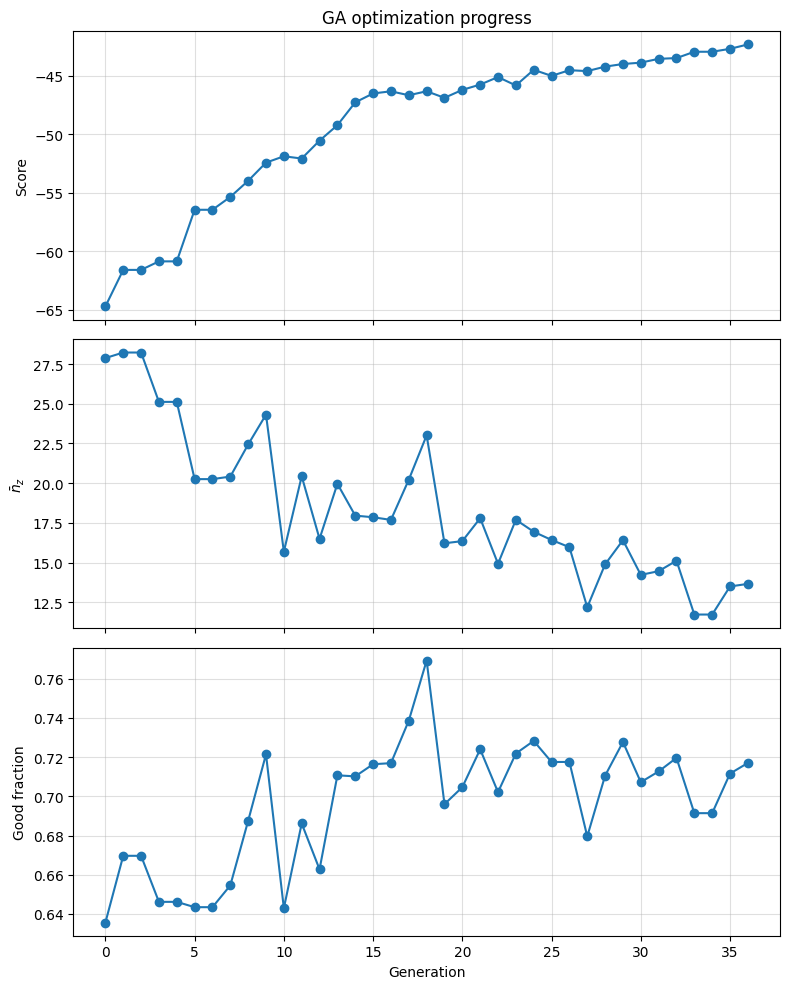

In [12]:
plot_ga_metrics(run)

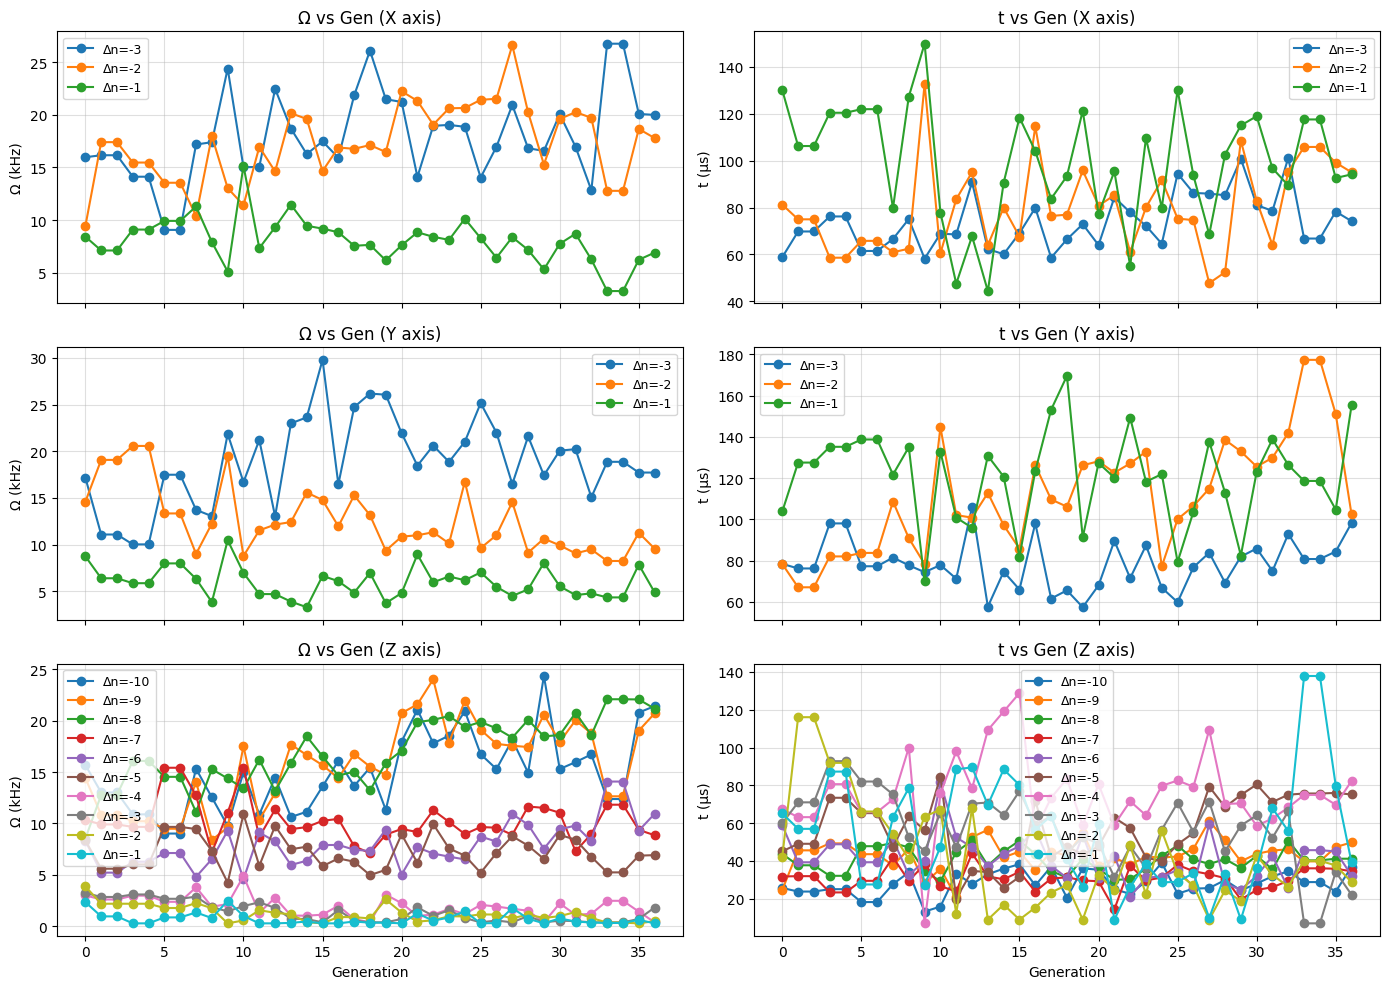

In [17]:
plot_omega_time_vs_generation_by_axis(run)

In [18]:
seq = np.load("../sequence_new.npy")

In [45]:
seq_half = np.concatenate((seq[:20], seq[40:100], seq[140:200],seq[240:300], seq[360:420]))

In [46]:
seq_half.shape

(260, 4)

In [47]:
np.save("../sequence_half.npy", seq_half)